# Librerías

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import Ridge

# Funciones

In [4]:
def readQAP(name):
    """
    Leer un archivo DAT y lo transforma en un diccionario que contiene el número de nodos (n), matriz de flujo (f) 
    y matriz de distancia (d)

    Args:
        name (str): Nombre del archivo .dat a leer

    Returns:
        instance_dict (dict): Diccionario que contiene el número de nodos (n), matriz de flujo (f) y matriz de distancia (d)
    """
    with open(name, 'r') as file:
        lines = file.readlines()
        
    n_nodos = int(lines[0])
    flow_matrix = np.array([list(map(int, line.split())) for line in lines[1:n_nodos+1]])
    distance_matrix = np.array([list(map(int, line.split())) for line in lines[n_nodos+2:2*n_nodos+2]])
    
    instance_dict = {'n': n_nodos, 'f': flow_matrix, 'd': distance_matrix}
    
    return instance_dict

In [5]:
def evaluateQAP(sol, f, d):
    """
    Evaluar QAP con una solución dada

    Args:
        sol (numpy array): vector con valores de posición para evaluar la función
        f (numpy array): matriz de flujo entre nodos
        d (numpy array): matriz de distancia entre nodos

    Returns:
        Valor de fitness del QAP en base a la solución entregada
    """
    
    fitness = np.sum(f * d[sol[:, None], sol])
    
    return fitness

In [6]:
def generateInitialSolution(n):
    """
    Generar una solución inicial para el problema QAP

    Args:
        n (int): El número de nodos en el problema QAP

    Returns:
        sol_ini (numpy array): Una permutación aleatoria de los números del 0 al n-1
    """
    sol_ini = np.random.permutation(n)
    return sol_ini

In [7]:
def inversion(sol, i):
    """
    Aplica el operador de inversión a una solución dada.

    Args:
        sol (numpy array): Vector con valores de posición para evaluar la función.
        i (int): Valor de posición intermedio al cual se le aplicará el operador de inversión.

    Returns:
        sol (numpy array): Vector con operador de inversión ya aplicado.
    """
    temp = sol[i:i+2].copy()
    sol[i:i+2] = sol[i+2:i+4][::-1]
    sol[i+2:i+4] = temp[::-1]
    return sol


def swap(sol, i, j):
    """
    Aplica el operador de swap a una solución dada.

    Args:
        sol (numpy array): Vector con valores de posición para evaluar la función.
        i, j (int): Indices de los elementos a intercambiar.

    Returns:
        sol (numpy array): Vector con operador de swap ya aplicado.
    """
    sol[i], sol[j] = sol[j], sol[i]
    return sol

def permutation(sol):
    """
    Aplica el operador de permutación a una solución dada.

    Args:
        sol (numpy array): Vector con valores de posición para evaluar la función.

    Returns:
        sol (numpy array): Vector con operador de permutación ya aplicado.
    """
    n = len(sol)
    length = np.random.randint(1, n//2 + 1)  # length of segments to swap
    i = np.random.randint(0, n - 2*length + 1)  # start index of first segment
    j = np.random.randint(i + length, n - length + 1)  # start index of second segment
    temp_i = copy.deepcopy(sol[i:i+length])
    temp_j = copy.deepcopy(sol[j:j+length])
    sol[i:i+length], sol[j:j+length] = temp_j, temp_i
    return sol

def insertion(sol):
    n = len(sol)
    # Seleccione dos índices diferentes
    i, j = np.random.choice(n, 2, replace=False)
    # Retire el elemento en el índice j e insértelo en el índice i
    sol = np.insert(np.delete(sol, j), i, sol[j])
    return sol

def displacement(sol):
    n = len(sol)
    # Seleccione dos índices diferentes para definir un segmento
    i, j = np.sort(np.random.choice(n, 2, replace=False))
    # Crea una copia del segmento que se va a desplazar
    segment = np.copy(sol[i:j+1])
    # Elimina el segmento de la solución
    sol = np.delete(sol, range(i, j+1))
    # Seleccione un índice para el nuevo lugar del segmento
    k = np.random.choice(len(sol) + 1)
    # Desplace el segmento a la nueva posición
    sol = np.insert(sol, k, segment)
    return sol



In [8]:
def calculate_initial_temperature(instance, sol, p0=0.5, n_iter=100):
    """
    Calcula la temperatura inicial para el algoritmo de Simulated Annealing.

    Args:
        instance (dict): Diccionario que contiene el número de nodos (n), matriz de flujo (f) y matriz de distancia (d).
        sol (numpy array): Solución inicial.
        p0 (float, optional): Probabilidad inicial. Por defecto es 0.5.
        n_iter (int, optional): Número de iteraciones para calcular la temperatura inicial. Por defecto es 100.

    Returns:
        t_initial (float): Temperatura inicial.
    """
    deltas = np.zeros(n_iter)
    cost_temp = evaluateQAP(sol, instance['f'], instance['d'])

    for i in range(n_iter):
        sol_temp = inversion(sol.copy(), np.random.randint(0, instance['n'] - 4))
        new_cost = evaluateQAP(sol_temp, instance['f'], instance['d'])
        deltas[i] = new_cost - cost_temp
        cost_temp = new_cost

    delta_average = np.mean(np.abs(deltas))
    t_initial = -delta_average / np.log(p0)

    return t_initial


In [9]:
def simulated_annealing(instance, xj_ini, operator, max_iter, max_iter_interna, alpha):
    """
    Calcula el menor costo al aplicar el algoritmo de S.A a una función objetivo dada.
    
    Args:
        instance (dict): Diccionario que contiene el número de nodos (n), matriz de flujo (f) y matriz de distancia (d).
        xj_ini (numpy array): Vector que contiene una configuración inicial de Xj para el modelo SIC
        operator (str): Nombre del operador a aplicar. Puede ser "swap" o "inversion"
        max_iter (int): Número de iteraciones máximas a realizar por el ciclo externo del algoritmo.
        max_iter_interna (int): Número máximo de iteraciones a realizar por el ciclo interno del algoritmo.
        alpha (float): Factor de enfriamiento de la temperatura por cada nuevo ciclo

    Returns:
        mejor_xj (numpy array): mejor configuración de Xj encontrada
        mejor_cost: mínimo valor de costo encontrado para el problema QAP
        eval_cost: costos de la solución actual para cada iteración
        eval_mejor: mejor costo encontrado para cada iteración
        temp: evolución de la temperatura para cada iteración
    """
    eval_cost = []
    eval_mejor = []
    temp = []

    xj = xj_ini.copy()
    mejor_xj = xj.copy()

    cost = evaluateQAP(xj, instance['f'], instance['d'])
    mejor_cost = cost

    t_inicial = calculate_initial_temperature(instance, xj, 0.5)
    t = t_inicial

    for iter_externa in range(max_iter):
        for iter_interna in range(max_iter_interna):
            if operator == "swap":
                i, j = np.random.choice(range(instance['n']), 2, replace=False)
                xj_test = swap(xj.copy(), i, j)
                
            elif operator == "inversion":
                i = np.random.choice(range(instance['n'] - 4))
                xj_test = inversion(xj.copy(), i)
                
            elif operator == "permutation":
                xj_test = permutation(xj.copy())
                
            elif operator == "insertion":
                xj_test = insertion(xj.copy())
                
            elif operator == "displacement":
                xj_test = displacement(xj.copy())

            cost_test = evaluateQAP(xj_test, instance['f'], instance['d'])

            delta_cost = cost - cost_test

            if np.exp(delta_cost / t) > np.random.rand():
                xj = xj_test
                cost = cost_test

            if cost_test < mejor_cost:
                mejor_xj = xj_test
                mejor_cost = cost_test

        eval_cost.append(cost)
        eval_mejor.append(mejor_cost)
        temp.append(t)

        t = t * alpha
        
    results_dict = {
        'mejor_xj': mejor_xj,
        'mejor_cost': mejor_cost,
        'eval_cost': eval_cost,
        'eval_mejor': eval_mejor,
        'temp': temp
    }
    
    return results_dict

In [10]:
def plot_convergence(results_dict):
    """Grafica la curva de convergencia de los costos y la temperatura.
    
    Args:
        results_dict (dict): Diccionario con los resultados del algoritmo.
    """
    # Crear una figura y un conjunto de subtramas
    fig, ax1 = plt.subplots()

    # Graficar los costos en el primer eje
    ax1.plot(results_dict['eval_cost'], label='Costo actual', color='blue')
    ax1.plot(results_dict['eval_mejor'], label='Mejor costo', color='green')
    ax1.set_xlabel('Iteraciones')
    ax1.set_ylabel('Costo')
    ax1.legend(loc='upper left')

    # Crear un segundo eje para la temperatura
    ax2 = ax1.twinx()
    ax2.plot(results_dict['temp'], label='Temperatura', color='red')
    ax2.set_ylabel('Temperatura')
    ax2.legend(loc='upper right')

    # Mostrar el gráfico
    plt.show()


In [11]:
def multiple_runs(instance, xj_ini, max_iter, max_iter_interna, alpha, num_runs=11):
    eval_cost_runs = []
    eval_mejor_runs = []
    temp_runs = []
    operator_performance_runs = {operator: [] for operator in ["swap", "inversion", "permutation"]}
    context_data_runs = []

    for _ in range(num_runs):
        results_dict = get_sa_context(instance, xj_ini, max_iter, max_iter_interna, alpha)
        eval_cost_runs.append(results_dict['eval_cost'])
        eval_mejor_runs.append(results_dict['eval_mejor'])
        temp_runs.append(results_dict['temp'])
        for operator in operator_performance_runs.keys():
            operator_performance_runs[operator].append(results_dict['operator_performance'][operator])
        context_data_runs.append(results_dict['context_data'])

    # Calculate average values
    avg_eval_cost = [sum(x) / len(x) for x in zip(*eval_cost_runs)]
    avg_eval_mejor = [sum(x) / len(x) for x in zip(*eval_mejor_runs)]
    avg_temp = [sum(x) / len(x) for x in zip(*temp_runs)]
    avg_operator_performance = {operator: [sum(x) / len(x) for x in zip(*operator_performance_runs[operator])] for operator in operator_performance_runs.keys()}

    avg_results_dict = {
        'avg_eval_cost': avg_eval_cost,
        'avg_eval_mejor': avg_eval_mejor,
        'avg_temp': avg_temp,
        'avg_operator_performance': avg_operator_performance,
        'context_data_runs': context_data_runs
    }

    return avg_results_dict


# Entrada

In [12]:
instance = readQAP("../DAT/tho40.dat")

In [13]:
sol_ini = generateInitialSolution(instance['n']) 

In [14]:
sol_ini

array([29, 26, 14, 13,  4, 17, 15, 23, 22, 18, 32, 39,  1,  6,  0, 30, 37,
       34, 33, 11, 38,  9, 21,  5, 19, 25, 16,  3, 20,  2,  7, 35,  8, 31,
       28, 36, 27, 10, 12, 24])

In [27]:
displacement(sol_ini)

array([30,  4, 32, 34, 29, 27, 23,  1, 14, 38,  3, 18, 36, 35, 24, 33, 25,
        8,  6,  0, 17,  5, 15, 31, 11, 19, 12, 13, 16, 21, 10, 26, 22, 28,
       37,  7, 39,  2, 20,  9])

# Parámetros

In [30]:
max_iter = 1000
max_iter_interna = 50
alpha = 0.8

# Evaluación Operadores

Se generan visualizaciones para evaluar el rendimiento de los operadores en simulated annealing por sí solos.

In [17]:
# Se definen los operadores a evaluar
operators = ['insertion', 'permutation', 'displacement']

# Se crean listas para almacenar los resultados
operator_performance = []
best_costs = {operator: [] for operator in operators}

# Ejecuta el algoritmo con cada operador y registra los resultados
for operator in operators:
    print(f"Running SA with {operator} operator...")
    results_dict = simulated_annealing(instance, sol_ini, operator, max_iter, max_iter_interna, alpha)
    operator_performance.append(results_dict['mejor_cost'])
    best_costs[operator] = results_dict['eval_mejor']

# Imprime el rendimiento de cada operador
for operator, performance in zip(operators, operator_performance):
    print(f"Best cost with {operator} operator: {performance}")


Running SA with insertion operator...


C:\Users\mbell\AppData\Local\Temp\ipykernel_8396\2632785922.py:56: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


Running SA with permutation operator...
Running SA with displacement operator...
Best cost with insertion operator: 14662770
Best cost with permutation operator: 14729960
Best cost with displacement operator: 14999956


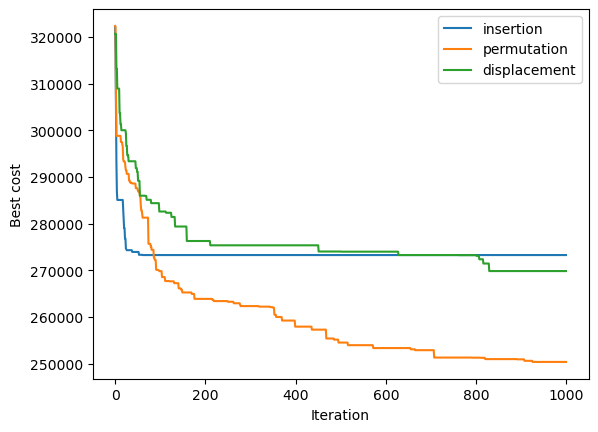

In [36]:
# Grafica la mejor solución encontrada en cada iteración para cada operador
for operator, costs in best_costs.items():
    plt.plot(costs, label=operator)
plt.xlabel('Iteration')
plt.ylabel('Best cost')
plt.legend()
plt.show()

In [181]:
results_sa_swap = simulated_annealing(instance, sol_ini, "swap", max_iter, max_iter_interna, alpha)

C:\Users\mbell\AppData\Local\Temp\ipykernel_21236\2632785922.py:56: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


In [155]:
results_sa_insertion = simulated_annealing(instance, sol_ini, "insertion", max_iter, max_iter_interna, alpha)

In [156]:
results_sa_insertion["mejor_xj"]

array([10,  6,  0,  3, 15, 20, 13, 27,  8, 19, 28,  4, 29, 23, 26, 22,  7,
       21, 24, 14, 18,  2,  9, 25, 16, 12,  1, 11,  5, 17])

In [251]:
sa_context = get_sa_context(instance, sol_ini, max_iter, max_iter_interna, alpha)

C:\Users\mbell\AppData\Local\Temp\ipykernel_21348\369861148.py:34: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


In [259]:
mult_runs = multiple_runs(instance, sol_ini, max_iter, max_iter_interna, alpha, num_runs=11)

C:\Users\mbell\AppData\Local\Temp\ipykernel_21348\369861148.py:34: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


In [281]:
# Supongamos que 'context_data' es tu lista de listas
df = pd.DataFrame(mult_runs['context_data_runs'][3], columns=['Operator', 'Cost', 'Temperature', 'Iteration'])


In [37]:
avg_cost = df.groupby('Operator')['Cost'].mean()
avg_cost.plot(kind='bar')
plt.ylabel('Average Cost')
plt.title('Average Cost by Operator')
plt.show()


NameError: name 'df' is not defined

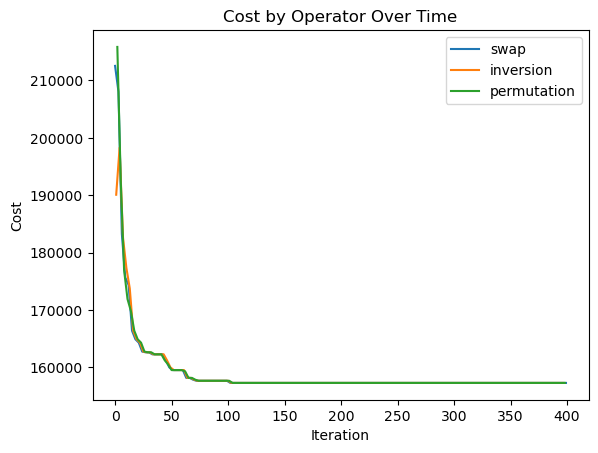

In [283]:
for operator in df['Operator'].unique():
    df[df['Operator'] == operator]['Cost'].plot(label=operator)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost by Operator Over Time')
plt.show()


# Bandidos Contextuales

Se define la clase para el modelo de bandidos contextuales LinUCB:

In [18]:
class LinUCB:
    def __init__(self, alpha=1, lambda_=1):
        self.alpha = alpha
        self.lambda_ = lambda_
        self.A = np.eye(2) * lambda_ 
        self.b = np.zeros(2)

    def update(self, reward, context):
        self.A += np.outer(context, context)
        self.b += reward * context

    def predict(self, context):
        theta = np.linalg.inv(self.A).dot(self.b)
        p = context.dot(theta) + self.alpha * np.sqrt(context.dot(np.linalg.inv(self.A)).dot(context))
        return p


Se adapta simulated annealing para que vaya variando los operadores dentro de cada ciclo externo. El modelo LinUCB escoge el operador dependiendo de la temperatura y costo que se tenga en cada iteración externa.

In [19]:
def lin_ucb_sa(instance, xj_ini, max_iter, max_iter_interna, alpha, alpha_ucb):
    
    eval_cost = []
    eval_mejor = []
    eval_operators = []
    temp = []

    xj = xj_ini.copy()
    mejor_xj = xj.copy()

    cost = evaluateQAP(xj, instance['f'], instance['d'])
    mejor_cost = cost

    t_inicial = calculate_initial_temperature(instance, xj, 0.5)
    t = t_inicial
    
    # Se definen los operadores a utilizar
    operators = ['insertion', 'permutation', 'displacement', 'lin_ucb_sa']

    # Inicializar bandidos, uno por cada operador
    bandits = [LinUCB(alpha_ucb) for _ in operators]

    for iter_externa in range(max_iter):
        
        # Definir el contexto
        context = np.array([cost, t])

        # Seleccionar la acción con mayor predicción
        predictions = [bandit.predict(context) for bandit in bandits]
        operator_idx = np.argmax(predictions)
        operator = operators[operator_idx]

        eval_operators.append(operator)
        
        print(f"Iteración externa {iter_externa}")
        print(f"Operador seleccionado: {operator}")
        print(f"Predicciones: {predictions}")

        
        for iter_interna in range(max_iter_interna):
            

            # Aquí aplicas el operador seleccionado al igual que en tu código anterior
            if operator == "swap":
                i, j = np.random.choice(range(instance['n']), 2, replace=False)
                xj_test = swap(xj.copy(), i, j)
                
            elif operator == "inversion":
                i = np.random.choice(range(instance['n'] - 4))
                xj_test = inversion(xj.copy(), i)
                
            elif operator == "permutation":
                xj_test = permutation(xj.copy())
                
            elif operator == "insertion":
                xj_test = insertion(xj.copy())
                
            elif operator == "displacement":
                xj_test = displacement(xj.copy())

            cost_test = evaluateQAP(xj_test, instance['f'], instance['d'])

            delta_cost = cost - cost_test

            if np.exp(delta_cost / t) > np.random.rand():
                xj = xj_test
                cost = cost_test

            if cost_test < mejor_cost:
                mejor_xj = xj_test
                mejor_cost = cost_test

        # Se calcula la recompensa, cómo un delta negativo es una mejora, se multplica la recompensa por -1
        reward = mejor_cost * -1 
        #reward = cost - mejor_cost
        
        print(f"Recompensa obtenida: {reward}")

        # Actualizar el bandido correspondiente
        bandits[operator_idx].update(reward, context)

        eval_cost.append(cost)
        eval_mejor.append(mejor_cost)
        temp.append(t)

        t = t * alpha
        
    results_dict = {
        'mejor_xj': mejor_xj,
        'mejor_cost': mejor_cost,
        'eval_cost': eval_cost,
        'eval_mejor': eval_mejor,
        'eval_operator': eval_operators,
        'temp': temp
    }
    
    return results_dict

Función para ejecutar n_runs veces s.a con los operadores por si solos y utilizando el modelo LinUCB 

In [20]:
def run_experiments(methods, n_runs):
    results = {method: [] for method in methods}
    
    sol_ini = generateInitialSolution(instance['n']) 
    
    
    max_iter = 600
    max_iter_interna = 50
    alpha = 0.9
    
    for method in methods:
        for i in range(n_runs):
            
            print("Ejecución " + str(i + 1) + " de " + str(n_runs))
            
            if method == 'swap' or method == 'inversion' or method == 'permutation' or method == 'displacement' or method == 'insertion':
                
                print("S.A utilizando método " + method)
                
                result = simulated_annealing(instance, sol_ini, method, max_iter, max_iter_interna, alpha)
            elif method == 'lin_ucb_sa':
                
                print("S.A utilizando método " + method)
                
                result = lin_ucb_sa(instance, sol_ini, max_iter, max_iter_interna, alpha, alpha_ucb=10)
            # Almacena el costo mínimo encontrado en cada ejecución
            results[method].append(result['mejor_cost'])
    
    return results

## Parámetros Entrada

In [21]:
instance = readQAP("../DAT/tai80a.dat")
sol_ini = generateInitialSolution(instance['n']) 


max_iter = 500
max_iter_interna = 20
alpha = 0.8

In [22]:
# Se ejecuta sa utilizando lin_ucb para seleccionar el operador
resultados_lin_ucb = lin_ucb_sa(instance, sol_ini, max_iter, max_iter_interna, alpha, alpha_ucb=5)

Iteración externa 0
Operador seleccionado: insertion
Predicciones: [78492598.72998257, 78492598.72998257, 78492598.72998257, 78492598.72998257]
Recompensa obtenida: -15523588
Iteración externa 1
Operador seleccionado: permutation
Predicciones: [-15314975.454404132, 77761594.3105976, 77761594.3105976, 77761594.3105976]
Recompensa obtenida: -15361906
Iteración externa 2
Operador seleccionado: displacement
Predicciones: [-15077060.456797745, -15123427.625897126, 76809830.84061767, 76809830.84061767]
Recompensa obtenida: -15361906
Iteración externa 3
Operador seleccionado: lin_ucb_sa
Predicciones: [-15150498.360366356, -15197235.316323753, -15437585.200893823, 77411661.04098707]
Recompensa obtenida: -15361906
Iteración externa 4
Operador seleccionado: insertion
Predicciones: [-15116073.022863023, -15162814.918949291, -15403169.76831774, -15327497.493850268]
Recompensa obtenida: -15361906
Iteración externa 5
Operador seleccionado: permutation
Predicciones: [-15286372.226733075, -15054376.17

C:\Users\mbell\AppData\Local\Temp\ipykernel_8396\3021389550.py:65: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


Recompensa obtenida: -14983758
Iteración externa 125
Operador seleccionado: insertion
Predicciones: [-14981663.650768617, -15029876.699971914, -14983750.356899973, -15108187.399015997]
Recompensa obtenida: -14983758
Iteración externa 126
Operador seleccionado: insertion
Predicciones: [-14981681.525381574, -15029876.69997196, -14983750.356899973, -15108187.399016071]
Recompensa obtenida: -14983758
Iteración externa 127
Operador seleccionado: insertion
Predicciones: [-14981699.097443262, -15029876.699971996, -14983750.356899973, -15108187.39901613]
Recompensa obtenida: -14983758
Iteración externa 128
Operador seleccionado: insertion
Predicciones: [-14981716.374570943, -15029876.699972026, -14983750.356899973, -15108187.39901618]
Recompensa obtenida: -14974396
Iteración externa 129
Operador seleccionado: insertion
Predicciones: [-14972294.762432372, -15020485.884552771, -14974388.361675458, -15098747.654298667]
Recompensa obtenida: -14974396
Iteración externa 130
Operador seleccionado: in

Recompensa obtenida: -14912888
Iteración externa 239
Operador seleccionado: insertion
Predicciones: [-14911524.763672393, -14958788.568294695, -14912880.393050216, -15036728.874327952]
Recompensa obtenida: -14912888
Iteración externa 240
Operador seleccionado: insertion
Predicciones: [-14911530.626980942, -14958788.568294695, -14912880.393050216, -15036728.874327952]
Recompensa obtenida: -14912888
Iteración externa 241
Operador seleccionado: insertion
Predicciones: [-14911536.440064553, -14958788.568294695, -14912880.393050216, -15036728.874327952]
Recompensa obtenida: -14912888
Iteración externa 242
Operador seleccionado: insertion
Predicciones: [-14911542.203565815, -14958788.568294695, -14912880.393050216, -15036728.874327952]
Recompensa obtenida: -14912888
Iteración externa 243
Operador seleccionado: insertion
Predicciones: [-14911547.918116406, -14958788.568294695, -14912880.393050216, -15036728.874327952]
Recompensa obtenida: -14912888
Iteración externa 244
Operador seleccionado:

Recompensa obtenida: -14909334
Iteración externa 356
Operador seleccionado: insertion
Predicciones: [-14908418.342055526, -14955223.62939274, -14909326.394863084, -15033145.360898538]
Recompensa obtenida: -14909334
Iteración externa 357
Operador seleccionado: insertion
Predicciones: [-14908420.960799016, -14955223.62939274, -14909326.394863084, -15033145.360898538]
Recompensa obtenida: -14909334
Iteración externa 358
Operador seleccionado: insertion
Predicciones: [-14908423.564604599, -14955223.62939274, -14909326.394863084, -15033145.360898538]
Recompensa obtenida: -14909334
Iteración externa 359
Operador seleccionado: insertion
Predicciones: [-14908426.153599722, -14955223.62939274, -14909326.394863084, -15033145.360898538]
Recompensa obtenida: -14909334
Iteración externa 360
Operador seleccionado: insertion
Predicciones: [-14908428.727910398, -14955223.62939274, -14909326.394863084, -15033145.360898538]
Recompensa obtenida: -14909334
Iteración externa 361
Operador seleccionado: inse

Recompensa obtenida: -14892586
Iteración externa 476
Operador seleccionado: insertion
Predicciones: [-14891869.858464371, -14938424.080509799, -14892578.40340611, -15016258.280730885]
Recompensa obtenida: -14892586
Iteración externa 477
Operador seleccionado: insertion
Predicciones: [-14891871.3797979, -14938424.080509799, -14892578.40340611, -15016258.280730885]
Recompensa obtenida: -14892586
Iteración externa 478
Operador seleccionado: insertion
Predicciones: [-14891872.894680673, -14938424.080509799, -14892578.40340611, -15016258.280730885]
Recompensa obtenida: -14892586
Iteración externa 479
Operador seleccionado: insertion
Predicciones: [-14891874.403153626, -14938424.080509799, -14892578.40340611, -15016258.280730885]
Recompensa obtenida: -14892586
Iteración externa 480
Operador seleccionado: insertion
Predicciones: [-14891875.905257365, -14938424.080509799, -14892578.40340611, -15016258.280730885]
Recompensa obtenida: -14872830
Iteración externa 481
Operador seleccionado: insert

In [24]:
# Mejor costo encontrado por lin_ucb
resultados_lin_ucb['mejor_xj']

array([78, 15, 22, 18, 13, 16, 27, 52, 12, 63, 47, 17, 37,  4, 40, 11,  5,
       74, 24, 51, 26, 54, 73, 23, 30, 55, 79, 58, 14, 69, 33, 21, 53, 70,
       77, 28, 75, 62, 38, 20, 66, 76, 32, 60,  2, 39,  7, 35, 48, 36, 45,
       71,  0,  1, 64, 42, 25, 34, 56, 49, 29,  3, 68, 57, 67, 10,  9, 72,
       31, 50,  8, 46, 61, 19, 44, 43, 41, 59,  6, 65])

In [52]:
# Se evalúa como varía el operador a medida avanza s.a
resultados_lin_ucb['eval_operator']

['insertion',
 'permutation',
 'displacement',
 'lin_ucb_sa',
 'displacement',
 'permutation',
 'insertion',
 'lin_ucb_sa',
 'permutation',
 'insertion',
 'permutation',
 'permutation',
 'insertion',
 'permutation',
 'permutation',
 'insertion',
 'permutation',
 'insertion',
 'permutation',
 'insertion',
 'permutation',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'permutation',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'permutation',
 'permutation',
 'insertion',
 'insertion',
 'insertion',
 'permutation',
 'insertion',
 'insertion',
 'permutation',
 'insertion',
 'permutation',
 'insertion',
 'insertion',
 'insertion',
 'permutation',
 'permutation',
 'permutation',
 'permutation',
 'permutation',
 'insertion',
 'insertion',
 'permutation',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertion',
 'insertio

In [53]:
# Se ejecuta 11 veces s.a utilizando los distintos operadores para evaluar sus resultados

methods = ['insertion', 'permutation', 'displacement', 'lin_ucb_sa']
n_runs = 11

results = run_experiments(methods, n_runs)


Ejecución 1 de 11
S.A utilizando método insertion


C:\Users\mbell\AppData\Local\Temp\ipykernel_9880\2632785922.py:56: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


Ejecución 2 de 11
S.A utilizando método insertion
Ejecución 3 de 11
S.A utilizando método insertion
Ejecución 4 de 11
S.A utilizando método insertion
Ejecución 5 de 11
S.A utilizando método insertion
Ejecución 6 de 11
S.A utilizando método insertion
Ejecución 7 de 11
S.A utilizando método insertion
Ejecución 8 de 11
S.A utilizando método insertion
Ejecución 9 de 11
S.A utilizando método insertion
Ejecución 10 de 11
S.A utilizando método insertion
Ejecución 11 de 11
S.A utilizando método insertion
Ejecución 1 de 11
S.A utilizando método permutation
Ejecución 2 de 11
S.A utilizando método permutation
Ejecución 3 de 11
S.A utilizando método permutation
Ejecución 4 de 11
S.A utilizando método permutation
Ejecución 5 de 11
S.A utilizando método permutation
Ejecución 6 de 11
S.A utilizando método permutation
Ejecución 7 de 11
S.A utilizando método permutation
Ejecución 8 de 11
S.A utilizando método permutation
Ejecución 9 de 11
S.A utilizando método permutation
Ejecución 10 de 11
S.A utiliza

Recompensa obtenida: -15205724
Iteración externa 88
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293324.296955243, -15287713.038688226, -15257313.254758427, -15206036.354098737]
Recompensa obtenida: -15205724
Iteración externa 89
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293328.057624321, -15287715.80277073, -15257318.43691804, -15206031.990040157]
Recompensa obtenida: -15205724
Iteración externa 90
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293331.442226492, -15287718.290444985, -15257323.100861695, -15206027.716962123]
Recompensa obtenida: -15205724
Iteración externa 91
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293334.488368444, -15287720.529351814, -15257327.29841098, -15206023.53429753]
Recompensa obtenida: -15205724
Iteración externa 92
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293337.229896203, -15287722.544367958, -15257331.07620534, -15206019.44122788]
Recompensa obtenida: -15205724
Iteración externa 93
Operador seleccionado: lin_uc

Recompensa obtenida: -15205724
Iteración externa 201
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903392106, -15287740.679326646, -15257365.076004667, -15205837.955742825]
Recompensa obtenida: -15205724
Iteración externa 202
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903417496, -15287740.679345306, -15257365.076039655, -15205837.310997467]
Recompensa obtenida: -15205724
Iteración externa 203
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903440349, -15287740.679362103, -15257365.076071143, -15205836.673488755]
Recompensa obtenida: -15205724
Iteración externa 204
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903460914, -15287740.679377219, -15257365.076099483, -15205836.043095604]
Recompensa obtenida: -15205724
Iteración externa 205
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903479423, -15287740.679390823, -15257365.07612499, -15205835.419699611]
Recompensa obtenida: -15205724
Iteración externa 206
Operador seleccion

Recompensa obtenida: -15205724
Iteración externa 316
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646007, -15287740.679513263, -15257365.07635454, -15205792.84227579]
Recompensa obtenida: -15205724
Iteración externa 317
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646007, -15287740.679513264, -15257365.07635454, -15205792.60577756]
Recompensa obtenida: -15205724
Iteración externa 318
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646007, -15287740.679513264, -15257365.07635454, -15205792.370893553]
Recompensa obtenida: -15205724
Iteración externa 319
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646007, -15287740.679513264, -15257365.07635454, -15205792.137607308]
Recompensa obtenida: -15205724
Iteración externa 320
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.07635454, -15205791.905902592]
Recompensa obtenida: -15205724
Iteración externa 321
Operador seleccionado: l

Recompensa obtenida: -15205724
Iteración externa 430
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205773.40450916]
Recompensa obtenida: -15205724
Iteración externa 431
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205773.282310462]
Recompensa obtenida: -15205724
Iteración externa 432
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205773.160712508]
Recompensa obtenida: -15205724
Iteración externa 433
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205773.039710894]
Recompensa obtenida: -15205724
Iteración externa 434
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205772.919301236]
Recompensa obtenida: -15205724
Iteración externa 435
Operador seleccion

Recompensa obtenida: -15205724
Iteración externa 543
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205762.583071332]
Recompensa obtenida: -15205724
Iteración externa 544
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205762.50835437]
Recompensa obtenida: -15205724
Iteración externa 545
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205762.433925003]
Recompensa obtenida: -15205724
Iteración externa 546
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205762.359781576]
Recompensa obtenida: -15205724
Iteración externa 547
Operador seleccionado: lin_ucb_sa
Predicciones: [-15293361.903646009, -15287740.679513264, -15257365.076354543, -15205762.285922447]
Recompensa obtenida: -15205724
Iteración externa 548
Operador seleccion

Recompensa obtenida: -15192848
Iteración externa 24
Operador seleccionado: displacement
Predicciones: [-15249760.814924464, -15197773.13039437, -15190503.983445898, -15251773.29196369]
Recompensa obtenida: -15192848
Iteración externa 25
Operador seleccionado: displacement
Predicciones: [-15254233.002341656, -15199261.34947838, -15191069.32138122, -15254223.426669033]
Recompensa obtenida: -15181270
Iteración externa 26
Operador seleccionado: displacement
Predicciones: [-15246602.518137937, -15189007.651394961, -15178636.834185624, -15244786.97074534]
Recompensa obtenida: -15181270
Iteración externa 27
Operador seleccionado: displacement
Predicciones: [-15250224.989567257, -15190213.107650992, -15179125.160505328, -15246771.57935786]
Recompensa obtenida: -15151254
Iteración externa 28
Operador seleccionado: displacement
Predicciones: [-15223268.417481394, -15161242.885222886, -15146578.014013719, -15218376.903731469]
Recompensa obtenida: -15151254
Iteración externa 29
Operador selecciona

C:\Users\mbell\AppData\Local\Temp\ipykernel_9880\3021389550.py:65: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


Recompensa obtenida: -15093622
Iteración externa 98
Operador seleccionado: displacement
Predicciones: [-15194574.507027134, -15113293.806270355, -15092759.786087269, -15176493.684928956]
Recompensa obtenida: -15093622
Iteración externa 99
Operador seleccionado: displacement
Predicciones: [-15194576.345534967, -15113294.418071995, -15092771.24373632, -15176494.692174064]
Recompensa obtenida: -15093622
Iteración externa 100
Operador seleccionado: displacement
Predicciones: [-15194578.000192015, -15113294.968693472, -15092782.394495472, -15176495.59869466]
Recompensa obtenida: -15093622
Iteración externa 101
Operador seleccionado: displacement
Predicciones: [-15194579.489383357, -15113295.464252802, -15092793.250926351, -15176496.414563196]
Recompensa obtenida: -15093622
Iteración externa 102
Operador seleccionado: displacement
Predicciones: [-15194580.829655565, -15113295.910256198, -15092803.824894173, -15176497.14884488]
Recompensa obtenida: -15093622
Iteración externa 103
Operador sel

Recompensa obtenida: -15060690
Iteración externa 170
Operador seleccionado: displacement
Predicciones: [-15161440.579561725, -15080324.986927567, -15060027.399389312, -15143390.916810844]
Recompensa obtenida: -15060690
Iteración externa 171
Operador seleccionado: displacement
Predicciones: [-15161440.580494821, -15080324.987238072, -15060031.862554042, -15143390.917322049]
Recompensa obtenida: -15060690
Iteración externa 172
Operador seleccionado: displacement
Predicciones: [-15161440.581334608, -15080324.987517528, -15060036.265962882, -15143390.917782133]
Recompensa obtenida: -15060690
Iteración externa 173
Operador seleccionado: displacement
Predicciones: [-15161440.582090413, -15080324.987769041, -15060040.610808395, -15143390.918196213]
Recompensa obtenida: -15060690
Iteración externa 174
Operador seleccionado: displacement
Predicciones: [-15161440.58277064, -15080324.9879954, -15060044.898251586, -15143390.91856888]
Recompensa obtenida: -15060690
Iteración externa 175
Operador se

Recompensa obtenida: -15060690
Iteración externa 246
Operador seleccionado: displacement
Predicciones: [-15161440.588889575, -15080324.990031602, -15060252.719633812, -15143390.921921201]
Recompensa obtenida: -15060690
Iteración externa 247
Operador seleccionado: displacement
Predicciones: [-15161440.588889886, -15080324.990031704, -15060254.667073945, -15143390.92192137]
Recompensa obtenida: -15060690
Iteración externa 248
Operador seleccionado: displacement
Predicciones: [-15161440.588890165, -15080324.990031797, -15060256.597235179, -15143390.921921525]
Recompensa obtenida: -15060690
Iteración externa 249
Operador seleccionado: displacement
Predicciones: [-15161440.588890417, -15080324.990031881, -15060258.510346487, -15143390.921921663]
Recompensa obtenida: -15060690
Iteración externa 250
Operador seleccionado: displacement
Predicciones: [-15161440.588890644, -15080324.990031958, -15060260.406632805, -15143390.921921786]
Recompensa obtenida: -15060690
Iteración externa 251
Operador

Recompensa obtenida: -15029780
Iteración externa 323
Operador seleccionado: displacement
Predicciones: [-15130323.81213128, -15049374.691909384, -15029352.534660785, -15112311.189626662]
Recompensa obtenida: -15029780
Iteración externa 324
Operador seleccionado: displacement
Predicciones: [-15130323.81213128, -15049374.691909384, -15029353.946898798, -15112311.189626662]
Recompensa obtenida: -15010956
Iteración externa 325
Operador seleccionado: displacement
Predicciones: [-15111373.886354618, -15030526.150600027, -15010469.93277509, -15093383.823701577]
Recompensa obtenida: -15010956
Iteración externa 326
Operador seleccionado: displacement
Predicciones: [-15111373.886354618, -15030526.150600027, -15010471.524224032, -15093383.823701577]
Recompensa obtenida: -15010956
Iteración externa 327
Operador seleccionado: displacement
Predicciones: [-15111373.886354618, -15030526.150600027, -15010473.105281172, -15093383.823701577]
Recompensa obtenida: -15010956
Iteración externa 328
Operador s

Recompensa obtenida: -14996388
Iteración externa 399
Operador seleccionado: displacement
Predicciones: [-15096708.431684282, -15015939.157942003, -14995958.768556148, -15078735.828227893]
Recompensa obtenida: -14996388
Iteración externa 400
Operador seleccionado: displacement
Predicciones: [-15096708.431684282, -15015939.157942003, -14995959.89778073, -15078735.828227893]
Recompensa obtenida: -14996388
Iteración externa 401
Operador seleccionado: displacement
Predicciones: [-15096708.431684282, -15015939.157942003, -14995961.021076716, -15078735.828227893]
Recompensa obtenida: -14996388
Iteración externa 402
Operador seleccionado: displacement
Predicciones: [-15096708.431684282, -15015939.157942003, -14995962.138490668, -15078735.828227893]
Recompensa obtenida: -14996388
Iteración externa 403
Operador seleccionado: displacement
Predicciones: [-15096708.431684282, -15015939.157942003, -14995963.250068672, -15078735.828227893]
Recompensa obtenida: -14996388
Iteración externa 404
Operador

Recompensa obtenida: -14986918
Iteración externa 472
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986537.288394758, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 473
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986538.127597904, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 474
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986538.963107767, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 475
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986539.794948678, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 476
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986540.623144755, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 477
Operador sel

Recompensa obtenida: -14986918
Iteración externa 548
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986592.016037397, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 549
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986592.631412888, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 550
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986593.244468248, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 551
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986593.855216583, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 552
Operador seleccionado: displacement
Predicciones: [-15087175.08079685, -15006456.811671305, -14986594.463670885, -15069213.826777054]
Recompensa obtenida: -14986918
Iteración externa 553
Operador sel

Recompensa obtenida: -15141886
Iteración externa 35
Operador seleccionado: displacement
Predicciones: [-15254668.727112278, -15155427.06760919, -15137106.65600902, -15166581.13355264]
Recompensa obtenida: -15141886
Iteración externa 36
Operador seleccionado: displacement
Predicciones: [-15255799.551795084, -15156153.342255143, -15137510.903621672, -15167215.491189323]
Recompensa obtenida: -15094680
Iteración externa 37
Operador seleccionado: displacement
Predicciones: [-15209224.430785496, -15109536.131862303, -15086802.07630804, -15120483.64742932]
Recompensa obtenida: -15094680
Iteración externa 38
Operador seleccionado: displacement
Predicciones: [-15210140.398741275, -15110124.414192699, -15087373.32457667, -15120997.477017324]
Recompensa obtenida: -15094680
Iteración externa 39
Operador seleccionado: displacement
Predicciones: [-15210964.769887121, -15110653.868239375, -15087870.573923869, -15121459.923609124]
Recompensa obtenida: -15094680
Iteración externa 40
Operador selecciona

Recompensa obtenida: -15080262
Iteración externa 111
Operador seleccionado: displacement
Predicciones: [-15203844.185502749, -15100978.724934775, -15079016.076598728, -15111172.274214787]
Recompensa obtenida: -15080262
Iteración externa 112
Operador seleccionado: displacement
Predicciones: [-15203844.56205557, -15100978.966776432, -15079030.66201385, -15111172.485449104]
Recompensa obtenida: -15080262
Iteración externa 113
Operador seleccionado: displacement
Predicciones: [-15203844.900953108, -15100979.184433924, -15079044.909793833, -15111172.675559988]
Recompensa obtenida: -15080262
Iteración externa 114
Operador seleccionado: displacement
Predicciones: [-15203845.205960896, -15100979.380325666, -15079058.831524426, -15111172.846659783]
Recompensa obtenida: -15080262
Iteración externa 115
Operador seleccionado: displacement
Predicciones: [-15203845.4804679, -15100979.556628235, -15079072.438267963, -15111173.000649601]
Recompensa obtenida: -15080262
Iteración externa 116
Operador se

Recompensa obtenida: -15080262
Iteración externa 189
Operador seleccionado: displacement
Predicciones: [-15203847.950015318, -15100981.142699052, -15079614.31827196, -15111174.385988206]
Recompensa obtenida: -15080262
Iteración externa 190
Operador seleccionado: displacement
Predicciones: [-15203847.950116884, -15100981.142764281, -15079618.279949602, -15111174.386045178]
Recompensa obtenida: -15080262
Iteración externa 191
Operador seleccionado: displacement
Predicciones: [-15203847.950208291, -15100981.142822988, -15079622.193435324, -15111174.386096457]
Recompensa obtenida: -15080262
Iteración externa 192
Operador seleccionado: displacement
Predicciones: [-15203847.950290559, -15100981.142875824, -15079626.059603233, -15111174.386142606]
Recompensa obtenida: -15080262
Iteración externa 193
Operador seleccionado: displacement
Predicciones: [-15203847.950364599, -15100981.142923377, -15079629.87930641, -15111174.386184141]
Recompensa obtenida: -15080262
Iteración externa 194
Operador 

Recompensa obtenida: -15056136
Iteración externa 265
Operador seleccionado: displacement
Predicciones: [-15179524.233334834, -15076821.996045567, -15055594.03444587, -15086998.931698281]
Recompensa obtenida: -15056136
Iteración externa 266
Operador seleccionado: displacement
Predicciones: [-15179524.23333487, -15076821.99604559, -15055596.291338153, -15086998.9316983]
Recompensa obtenida: -15056136
Iteración externa 267
Operador seleccionado: displacement
Predicciones: [-15179524.233334899, -15076821.99604561, -15055598.529503424, -15086998.931698317]
Recompensa obtenida: -15051160
Iteración externa 268
Operador seleccionado: displacement
Predicciones: [-15174507.453957729, -15071839.159396682, -15050604.370444864, -15082012.731607944]
Recompensa obtenida: -15051160
Iteración externa 269
Operador seleccionado: displacement
Predicciones: [-15174507.453957753, -15071839.159396697, -15050606.654209938, -15082012.731607957]
Recompensa obtenida: -15051160
Iteración externa 270
Operador sele

Recompensa obtenida: -15032682
Iteración externa 339
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032193.756663619, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 340
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032195.306478372, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 341
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032196.846480975, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 342
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032198.376764316, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 343
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032199.897420127, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 344
Operado

Recompensa obtenida: -15032682
Iteración externa 416
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032289.89088966, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 417
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032290.890902353, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 418
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032291.885824816, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 419
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032292.87569582, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 420
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032293.860553749, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 421
Operador 

Recompensa obtenida: -15032682
Iteración externa 491
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032352.979779523, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 492
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032353.684047937, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 493
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032354.385306228, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 494
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032355.083573662, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 495
Operador seleccionado: displacement
Predicciones: [-15155878.022822155, -15053335.772017572, -15032355.778869323, -15063496.854343163]
Recompensa obtenida: -15032682
Iteración externa 496
Operado

Recompensa obtenida: -15013982
Iteración externa 567
Operador seleccionado: displacement
Predicciones: [-15137024.772349166, -15034610.079627037, -15013664.961064888, -15044758.522009902]
Recompensa obtenida: -15013982
Iteración externa 568
Operador seleccionado: displacement
Predicciones: [-15137024.772349166, -15034610.079627037, -15013665.543296112, -15044758.522009902]
Recompensa obtenida: -15013982
Iteración externa 569
Operador seleccionado: displacement
Predicciones: [-15137024.772349166, -15034610.079627037, -15013666.123391684, -15044758.522009902]
Recompensa obtenida: -15013982
Iteración externa 570
Operador seleccionado: displacement
Predicciones: [-15137024.772349166, -15034610.079627037, -15013666.701363323, -15044758.522009902]
Recompensa obtenida: -15013982
Iteración externa 571
Operador seleccionado: displacement
Predicciones: [-15137024.772349166, -15034610.079627037, -15013667.277222687, -15044758.522009902]
Recompensa obtenida: -15013982
Iteración externa 572
Operado

Recompensa obtenida: -15146824
Iteración externa 54
Operador seleccionado: displacement
Predicciones: [-15123606.319129907, -15359923.3949267, -15121109.633429803, -15123774.603543814]
Recompensa obtenida: -15146824
Iteración externa 55
Operador seleccionado: displacement
Predicciones: [-15123732.214381706, -15360131.317233253, -15122367.163455166, -15123896.480354162]
Recompensa obtenida: -15129816
Iteración externa 56
Operador seleccionado: displacement
Predicciones: [-15106862.177028032, -15343068.828476157, -15105772.83295615, -15107022.682563212]
Recompensa obtenida: -15129816
Iteración externa 57
Operador seleccionado: displacement
Predicciones: [-15106964.152178725, -15343237.245544052, -15106847.906561768, -15107121.402777022]
Recompensa obtenida: -15129816
Iteración externa 58
Operador seleccionado: insertion
Predicciones: [-15107055.929813089, -15343388.820904996, -15107834.096768398, -15107210.250968464]
Recompensa obtenida: -15129816
Iteración externa 59
Operador selecciona

Recompensa obtenida: -14934076
Iteración externa 144
Operador seleccionado: insertion
Predicciones: [-14925875.790137619, -15146232.121664802, -14925935.137155332, -14926362.502201008]
Recompensa obtenida: -14934076
Iteración externa 145
Operador seleccionado: displacement
Predicciones: [-14926052.558131097, -15146232.137503771, -14925935.142945658, -14926362.512283009]
Recompensa obtenida: -14934076
Iteración externa 146
Operador seleccionado: insertion
Predicciones: [-14926052.567250656, -15146232.151758844, -14926056.050986618, -14926362.52135681]
Recompensa obtenida: -14934076
Iteración externa 147
Operador seleccionado: displacement
Predicciones: [-14926221.873109108, -15146232.16458841, -14926056.055683888, -14926362.529523231]
Recompensa obtenida: -14934076
Iteración externa 148
Operador seleccionado: displacement
Predicciones: [-14926221.880500883, -15146232.176135018, -14926173.42383676, -14926362.53687301]
Recompensa obtenida: -14934076
Iteración externa 149
Operador seleccio

Recompensa obtenida: -14906158
Iteración externa 189
Operador seleccionado: displacement
Predicciones: [-14900045.324539497, -15117917.670336446, -14899982.432044398, -14900135.673063882]
Recompensa obtenida: -14906158
Iteración externa 190
Operador seleccionado: insertion
Predicciones: [-14900045.324628597, -15117917.67047469, -14900052.126138523, -14900135.673152724]
Recompensa obtenida: -14906158
Iteración externa 191
Operador seleccionado: displacement
Predicciones: [-14900137.12582647, -15117917.670599107, -14900052.12618516, -14900135.673232684]
Recompensa obtenida: -14906158
Iteración externa 192
Operador seleccionado: displacement
Predicciones: [-14900137.125898669, -15117917.670711083, -14900120.264667058, -14900135.673304647]
Recompensa obtenida: -14906158
Iteración externa 193
Operador seleccionado: lin_ucb_sa
Predicciones: [-14900137.125963647, -15117917.670811862, -14900186.899051191, -14900135.673369415]
Recompensa obtenida: -14906158
Iteración externa 194
Operador selecc

Recompensa obtenida: -14875420
Iteración externa 234
Operador seleccionado: displacement
Predicciones: [-14870442.425620113, -15086743.001923125, -14870400.55560904, -14870482.103067178]
Recompensa obtenida: -14875420
Iteración externa 235
Operador seleccionado: insertion
Predicciones: [-14870442.425620895, -15086743.001924332, -14870446.599436903, -14870482.103067959]
Recompensa obtenida: -14875420
Iteración externa 236
Operador seleccionado: displacement
Predicciones: [-14870499.055573488, -15086743.001925418, -14870446.599437315, -14870482.103068661]
Recompensa obtenida: -14875420
Iteración externa 237
Operador seleccionado: lin_ucb_sa
Predicciones: [-14870499.055574121, -15086743.001926394, -14870491.806155488, -14870482.103069294]
Recompensa obtenida: -14875420
Iteración externa 238
Operador seleccionado: displacement
Predicciones: [-14870499.05557469, -15086743.001927275, -14870491.806155821, -14870692.467504272]
Recompensa obtenida: -14875420
Iteración externa 239
Operador selec

Recompensa obtenida: -14853800
Iteración externa 279
Operador seleccionado: displacement
Predicciones: [-14849596.35889205, -15064815.86416675, -14849570.902442997, -14849614.283819908]
Recompensa obtenida: -14853800
Iteración externa 280
Operador seleccionado: insertion
Predicciones: [-14849596.358892057, -15064815.86416676, -14849603.587219832, -14849614.283819916]
Recompensa obtenida: -14853800
Iteración externa 281
Operador seleccionado: displacement
Predicciones: [-14849634.854043059, -15064815.86416677, -14849603.587219836, -14849614.283819921]
Recompensa obtenida: -14853800
Iteración externa 282
Operador seleccionado: lin_ucb_sa
Predicciones: [-14849634.854043065, -15064815.86416678, -14849635.770620868, -14849614.283819927]
Recompensa obtenida: -14853800
Iteración externa 283
Operador seleccionado: insertion
Predicciones: [-14849634.85404307, -15064815.864166787, -14849635.770620871, -14849766.206979884]
Recompensa obtenida: -14853800
Iteración externa 284
Operador seleccionado

Recompensa obtenida: -14851574
Iteración externa 366
Operador seleccionado: displacement
Predicciones: [-14848404.622331386, -15062558.241194038, -14848387.595692445, -14848448.131608104]
Recompensa obtenida: -14851574
Iteración externa 367
Operador seleccionado: insertion
Predicciones: [-14848404.622331386, -15062558.241194038, -14848406.182080308, -14848448.131608104]
Recompensa obtenida: -14851574
Iteración externa 368
Operador seleccionado: displacement
Predicciones: [-14848426.444071418, -15062558.241194038, -14848406.182080308, -14848448.131608104]
Recompensa obtenida: -14851574
Iteración externa 369
Operador seleccionado: displacement
Predicciones: [-14848426.444071418, -15062558.241194038, -14848424.552876465, -14848448.131608104]
Recompensa obtenida: -14851574
Iteración externa 370
Operador seleccionado: insertion
Predicciones: [-14848426.444071418, -15062558.241194038, -14848442.711810477, -14848448.131608104]
Recompensa obtenida: -14851574
Iteración externa 371
Operador sele

Recompensa obtenida: -14832444
Iteración externa 411
Operador seleccionado: insertion
Predicciones: [-14829530.021923572, -15043156.476831956, -14829625.50603038, -14829637.784126047]
Recompensa obtenida: -14832444
Iteración externa 412
Operador seleccionado: insertion
Predicciones: [-14829547.718736622, -15043156.476831956, -14829625.50603038, -14829637.784126047]
Recompensa obtenida: -14832444
Iteración externa 413
Operador seleccionado: insertion
Predicciones: [-14829565.201877674, -15043156.476831956, -14829625.50603038, -14829637.784126047]
Recompensa obtenida: -14832444
Iteración externa 414
Operador seleccionado: insertion
Predicciones: [-14829582.4751934, -15043156.476831956, -14829625.50603038, -14829637.784126047]
Recompensa obtenida: -14832444
Iteración externa 415
Operador seleccionado: insertion
Predicciones: [-14829599.542438675, -15043156.476831956, -14829625.50603038, -14829637.784126047]
Recompensa obtenida: -14832444
Iteración externa 416
Operador seleccionado: insert

Recompensa obtenida: -14795346
Iteración externa 461
Operador seleccionado: insertion
Predicciones: [-14792711.434661595, -15005531.455697374, -14792749.456147512, -14792743.377729908]
Recompensa obtenida: -14795346
Iteración externa 462
Operador seleccionado: insertion
Predicciones: [-14792724.83648138, -15005531.455697374, -14792749.456147512, -14792743.377729908]
Recompensa obtenida: -14795346
Iteración externa 463
Operador seleccionado: insertion
Predicciones: [-14792738.102629604, -15005531.455697374, -14792749.456147512, -14792743.377729908]
Recompensa obtenida: -14795346
Iteración externa 464
Operador seleccionado: lin_ucb_sa
Predicciones: [-14792751.235156102, -15005531.455697374, -14792749.456147512, -14792743.377729908]
Recompensa obtenida: -14795346
Iteración externa 465
Operador seleccionado: displacement
Predicciones: [-14792751.235156102, -15005531.455697374, -14792749.456147512, -14792802.691920027]
Recompensa obtenida: -14795346
Iteración externa 466
Operador selecciona

Recompensa obtenida: -14793532
Iteración externa 506
Operador seleccionado: displacement
Predicciones: [-14791155.72340042, -15003691.685673703, -14791151.175502464, -14791151.702668196]
Recompensa obtenida: -14793532
Iteración externa 507
Operador seleccionado: lin_ucb_sa
Predicciones: [-14791155.72340042, -15003691.685673703, -14791161.526248327, -14791151.702668196]
Recompensa obtenida: -14793532
Iteración externa 508
Operador seleccionado: insertion
Predicciones: [-14791155.72340042, -15003691.685673703, -14791161.526248327, -14791201.404905884]
Recompensa obtenida: -14793532
Iteración externa 509
Operador seleccionado: displacement
Predicciones: [-14791166.592025883, -15003691.685673703, -14791161.526248327, -14791201.404905884]
Recompensa obtenida: -14793532
Iteración externa 510
Operador seleccionado: insertion
Predicciones: [-14791166.592025883, -15003691.685673703, -14791171.787373811, -14791201.404905884]
Recompensa obtenida: -14793532
Iteración externa 511
Operador seleccion

Recompensa obtenida: -14789624
Iteración externa 595
Operador seleccionado: displacement
Predicciones: [-14787601.900286885, -14999728.167893931, -14787597.60479939, -14787627.397601321]
Recompensa obtenida: -14789624
Iteración externa 596
Operador seleccionado: insertion
Predicciones: [-14787601.900286885, -14999728.167893931, -14787605.105761131, -14787627.397601321]
Recompensa obtenida: -14789624
Iteración externa 597
Operador seleccionado: displacement
Predicciones: [-14787609.714670481, -14999728.167893931, -14787605.105761131, -14787627.397601321]
Recompensa obtenida: -14789624
Iteración externa 598
Operador seleccionado: insertion
Predicciones: [-14787609.714670481, -14999728.167893931, -14787612.551389918, -14787627.397601321]
Recompensa obtenida: -14789624
Iteración externa 599
Operador seleccionado: displacement
Predicciones: [-14787617.468882462, -14999728.167893931, -14787612.551389918, -14787627.397601321]
Recompensa obtenida: -14789624
Ejecución 5 de 11
S.A utilizando mét

Recompensa obtenida: -15290914
Iteración externa 91
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590465.686401917, -15951505.823427971, -15614224.86040147, -15288301.339287296]
Recompensa obtenida: -15290914
Iteración externa 92
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590467.608333962, -15951511.668565208, -15614226.936659379, -15288339.009284226]
Recompensa obtenida: -15290914
Iteración externa 93
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590469.338072803, -15951516.92918872, -15614228.8052915, -15288375.636048019]
Recompensa obtenida: -15290914
Iteración externa 94
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590470.894837761, -15951521.663749881, -15614230.487060407, -15288411.260416562]
Recompensa obtenida: -15290914
Iteración externa 95
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590472.29592622, -15951525.924854927, -15614232.000652425, -15288445.921249093]
Recompensa obtenida: -15290914
Iteración externa 96
Operador seleccionado: lin_u

Recompensa obtenida: -15290914
Iteración externa 205
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905605583, -15951564.274445157, -15614245.622854412, -15289940.116774136]
Recompensa obtenida: -15290914
Iteración externa 206
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905617261, -15951564.274480676, -15614245.622867027, -15289945.45102291]
Recompensa obtenida: -15290914
Iteración externa 207
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905627772, -15951564.27451264, -15614245.622878382, -15289950.727139194]
Recompensa obtenida: -15290914
Iteración externa 208
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.90563723, -15951564.27454141, -15614245.622888602, -15289955.946068147]
Recompensa obtenida: -15290914
Iteración externa 209
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905645745, -15951564.2745673, -15614245.622897798, -15289961.108734563]
Recompensa obtenida: -15290914
Iteración externa 210
Operador seleccionado: 

Recompensa obtenida: -15290914
Iteración externa 324
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.27480033, -15614245.622980572, -15290325.649628798]
Recompensa obtenida: -15290914
Iteración externa 325
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.27480033, -15614245.622980572, -15290327.60006953]
Recompensa obtenida: -15290914
Iteración externa 326
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.27480033, -15614245.622980572, -15290329.537616467]
Recompensa obtenida: -15290914
Iteración externa 327
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290331.462397035]
Recompensa obtenida: -15290914
Iteración externa 328
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290333.374537012]
Recompensa obtenida: -15290914
Iteración externa 329
Operador seleccionado

Recompensa obtenida: -15290914
Iteración externa 442
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290491.465053864]
Recompensa obtenida: -15290914
Iteración externa 443
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290492.471700974]
Recompensa obtenida: -15290914
Iteración externa 444
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290493.47356095]
Recompensa obtenida: -15290914
Iteración externa 445
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290494.47066785]
Recompensa obtenida: -15290914
Iteración externa 446
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290495.463055426]
Recompensa obtenida: -15290914
Iteración externa 447
Operador selecciona

Recompensa obtenida: -15290914
Iteración externa 557
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290582.49582232]
Recompensa obtenida: -15290914
Iteración externa 558
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290583.11562857]
Recompensa obtenida: -15290914
Iteración externa 559
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290583.733120343]
Recompensa obtenida: -15290914
Iteración externa 560
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290584.348310571]
Recompensa obtenida: -15290914
Iteración externa 561
Operador seleccionado: lin_ucb_sa
Predicciones: [-15590484.905722367, -15951564.274800332, -15614245.622980572, -15290584.961212108]
Recompensa obtenida: -15290914
Iteración externa 562
Operador selecciona

Recompensa obtenida: -15169674
Iteración externa 46
Operador seleccionado: lin_ucb_sa
Predicciones: [-15198596.556921512, -15177359.35552909, -15187439.307179652, -15170623.811402868]
Recompensa obtenida: -15169674
Iteración externa 47
Operador seleccionado: lin_ucb_sa
Predicciones: [-15198889.671173394, -15177400.388698496, -15187554.915749408, -15170600.36380232]
Recompensa obtenida: -15169674
Iteración externa 48
Operador seleccionado: lin_ucb_sa
Predicciones: [-15199153.473993672, -15177437.318544883, -15187658.96345782, -15170577.631335398]
Recompensa obtenida: -15169674
Iteración externa 49
Operador seleccionado: lin_ucb_sa
Predicciones: [-15199390.896526748, -15177470.555401726, -15187752.606391862, -15170555.587017765]
Recompensa obtenida: -15169674
Iteración externa 50
Operador seleccionado: lin_ucb_sa
Predicciones: [-15199604.576802338, -15177500.46856892, -15187836.885029653, -15170534.208814966]
Recompensa obtenida: -15169674
Iteración externa 51
Operador seleccionado: lin_

Recompensa obtenida: -15169674
Iteración externa 161
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.683077, -15177769.684662396, -15188595.386327447, -15169855.61008424]
Recompensa obtenida: -15169674
Iteración externa 162
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.68467997, -15177769.684886796, -15188595.386959681, -15169854.258800931]
Recompensa obtenida: -15169674
Iteración externa 163
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.686122645, -15177769.685088757, -15188595.387528693, -15169852.927433906]
Recompensa obtenida: -15169674
Iteración externa 164
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.68742105, -15177769.685270522, -15188595.388040805, -15169851.61554693]
Recompensa obtenida: -15169674
Iteración externa 165
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.688589614, -15177769.685434109, -15188595.388501702, -15169850.322716346]
Recompensa obtenida: -15169674
Iteración externa 166
Operador seleccionado: l

Recompensa obtenida: -15169674
Iteración externa 270
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.699106535, -15177769.686906375, -15188595.39264973, -15169773.883836148]
Recompensa obtenida: -15169674
Iteración externa 271
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.699106552, -15177769.686906377, -15188595.392649738, -15169773.472667746]
Recompensa obtenida: -15169674
Iteración externa 272
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.699106567, -15177769.686906379, -15188595.392649744, -15169773.064862534]
Recompensa obtenida: -15169674
Iteración externa 273
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.69910658, -15177769.68690638, -15188595.39264975, -15169772.660379427]
Recompensa obtenida: -15169674
Iteración externa 274
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.699106593, -15177769.686906382, -15188595.392649753, -15169772.259178007]
Recompensa obtenida: -15169674
Iteración externa 275
Operador seleccionado

Recompensa obtenida: -15169674
Iteración externa 377
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169743.233042853]
Recompensa obtenida: -15169674
Iteración externa 378
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169743.034870857]
Recompensa obtenida: -15169674
Iteración externa 379
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169742.83782686]
Recompensa obtenida: -15169674
Iteración externa 380
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169742.641901264]
Recompensa obtenida: -15169674
Iteración externa 381
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169742.447084578]
Recompensa obtenida: -15169674
Iteración externa 382
Operador seleccionado: lin_u

Recompensa obtenida: -15169674
Iteración externa 491
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169726.151334157]
Recompensa obtenida: -15169674
Iteración externa 492
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169726.038610557]
Recompensa obtenida: -15169674
Iteración externa 493
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169725.926371586]
Recompensa obtenida: -15169674
Iteración externa 494
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169725.814614132]
Recompensa obtenida: -15169674
Iteración externa 495
Operador seleccionado: lin_ucb_sa
Predicciones: [-15201527.6991067, -15177769.686906397, -15188595.392649796, -15169725.7033351]
Recompensa obtenida: -15169674
Iteración externa 496
Operador seleccionado: lin_uc

Recompensa obtenida: -15295230
Iteración externa 3
Operador seleccionado: lin_ucb_sa
Predicciones: [-14976050.118000947, -15253180.09941323, -15264320.402892252, 154739892.29766843]
Recompensa obtenida: -15295230
Iteración externa 4
Operador seleccionado: insertion
Predicciones: [-14993488.789998287, -15271723.196180431, -15282908.857195025, -15313945.103801807]
Recompensa obtenida: -15295230
Iteración externa 5
Operador seleccionado: permutation
Predicciones: [-15283789.045820039, -15202253.091353776, -15213414.87149015, -15244383.829694733]
Recompensa obtenida: -15295230
Iteración externa 6
Operador seleccionado: displacement
Predicciones: [-15458503.247550312, -15430466.639967578, -15328646.674005413, -15359925.09571284]
Recompensa obtenida: -15295230
Iteración externa 7
Operador seleccionado: displacement
Predicciones: [-15231953.262987535, -15177032.21167081, -15025462.69552222, -15094342.188857663]
Recompensa obtenida: -15295230
Iteración externa 8
Operador seleccionado: lin_ucb_

Recompensa obtenida: -14905302
Iteración externa 78
Operador seleccionado: permutation
Predicciones: [-14925348.920393607, -14904061.58933946, -14916776.793191992, -14984921.901479088]
Recompensa obtenida: -14905302
Iteración externa 79
Operador seleccionado: permutation
Predicciones: [-14925359.384303112, -14904089.204782117, -14916785.333744673, -14984931.575150896]
Recompensa obtenida: -14905302
Iteración externa 80
Operador seleccionado: permutation
Predicciones: [-14925368.801821658, -14904115.406565685, -14916793.020242076, -14984940.281455519]
Recompensa obtenida: -14905302
Iteración externa 81
Operador seleccionado: permutation
Predicciones: [-14925377.277588347, -14904140.302747495, -14916799.938089738, -14984948.117129678]
Recompensa obtenida: -14905302
Iteración externa 82
Operador seleccionado: permutation
Predicciones: [-14925384.90577836, -14904163.991482964, -14916806.16415263, -14984955.169236418]
Recompensa obtenida: -14905302
Iteración externa 83
Operador seleccionado

Recompensa obtenida: -14797668
Iteración externa 159
Operador seleccionado: permutation
Predicciones: [-14817674.020697564, -14796406.039469933, -14809144.703547854, -14876808.970280286]
Recompensa obtenida: -14796036
Iteración externa 160
Operador seleccionado: permutation
Predicciones: [-14816039.816335814, -14794771.49736245, -14807511.439486664, -14875168.243908819]
Recompensa obtenida: -14796036
Iteración externa 161
Operador seleccionado: permutation
Predicciones: [-14816039.818187552, -14794780.58405695, -14807511.440998038, -14875168.245620715]
Recompensa obtenida: -14796036
Iteración externa 162
Operador seleccionado: permutation
Predicciones: [-14816039.819854118, -14794789.540982185, -14807511.442358274, -14875168.24716142]
Recompensa obtenida: -14796036
Iteración externa 163
Operador seleccionado: permutation
Predicciones: [-14816039.821354026, -14794798.37090475, -14807511.443582486, -14875168.248548055]
Recompensa obtenida: -14796036
Iteración externa 164
Operador selecci

Recompensa obtenida: -14708612
Iteración externa 237
Operador seleccionado: permutation
Predicciones: [-14728497.639997477, -14707398.807955304, -14720019.650614923, -14787276.69938734]
Recompensa obtenida: -14676000
Iteración externa 238
Operador seleccionado: permutation
Predicciones: [-14695841.549468499, -14674645.889028775, -14687382.357521644, -14754490.283666195]
Recompensa obtenida: -14676000
Iteración externa 239
Operador seleccionado: permutation
Predicciones: [-14695841.549468998, -14674652.038927112, -14687382.357522052, -14754490.283666657]
Recompensa obtenida: -14676000
Iteración externa 240
Operador seleccionado: permutation
Predicciones: [-14695841.549469447, -14674658.133206269, -14687382.357522419, -14754490.283667073]
Recompensa obtenida: -14674372
Iteración externa 241
Operador seleccionado: permutation
Predicciones: [-14694211.348458504, -14673028.992552746, -14685753.09488456, -14752853.5767867]
Recompensa obtenida: -14674372
Iteración externa 242
Operador selecci

Recompensa obtenida: -14642768
Iteración externa 317
Operador seleccionado: permutation
Predicciones: [-14662564.620720964, -14641662.996770047, -14654124.58357469, -14721080.552060904]
Recompensa obtenida: -14642768
Iteración externa 318
Operador seleccionado: permutation
Predicciones: [-14662564.620720964, -14641666.675660519, -14654124.583574692, -14721080.552060904]
Recompensa obtenida: -14642768
Iteración externa 319
Operador seleccionado: permutation
Predicciones: [-14662564.620720964, -14641670.330131223, -14654124.583574692, -14721080.552060906]
Recompensa obtenida: -14642768
Iteración externa 320
Operador seleccionado: permutation
Predicciones: [-14662564.620720966, -14641673.960424514, -14654124.583574692, -14721080.552060906]
Recompensa obtenida: -14642768
Iteración externa 321
Operador seleccionado: permutation
Predicciones: [-14662564.620720966, -14641677.566779528, -14654124.583574692, -14721080.552060906]
Recompensa obtenida: -14639328
Iteración externa 322
Operador sele

Recompensa obtenida: -14608238
Iteración externa 395
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607271.63678874, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 396
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607274.180202136, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 397
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607276.710259786, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 398
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607279.22706661, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 399
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607281.730726445, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 400
Operador selec

Recompensa obtenida: -14608238
Iteración externa 473
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607436.587690864, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 474
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607438.337575663, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 475
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607440.079833701, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 476
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607441.814514723, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 477
Operador seleccionado: permutation
Predicciones: [-14627987.937108036, -14607443.54166806, -14619567.802925648, -14686365.878478518]
Recompensa obtenida: -14608238
Iteración externa 478
Operador sele

Recompensa obtenida: -14577686
Iteración externa 554
Operador seleccionado: permutation
Predicciones: [-14597394.631642003, -14576949.880153367, -14588992.107519057, -14655650.480062962]
Recompensa obtenida: -14577686
Iteración externa 555
Operador seleccionado: permutation
Predicciones: [-14597394.631642003, -14576951.240429036, -14588992.107519057, -14655650.480062962]
Recompensa obtenida: -14577686
Iteración externa 556
Operador seleccionado: permutation
Predicciones: [-14597394.631642003, -14576952.595685583, -14588992.107519057, -14655650.480062962]
Recompensa obtenida: -14577686
Iteración externa 557
Operador seleccionado: permutation
Predicciones: [-14597394.631642003, -14576953.945950722, -14588992.107519057, -14655650.480062962]
Recompensa obtenida: -14577686
Iteración externa 558
Operador seleccionado: permutation
Predicciones: [-14597394.631642003, -14576955.291251983, -14588992.107519057, -14655650.480062962]
Recompensa obtenida: -14577686
Iteración externa 559
Operador sel

Recompensa obtenida: -15070790
Iteración externa 22
Operador seleccionado: permutation
Predicciones: [-15127064.847837534, -15004053.347096983, -15112758.38727222, -15079015.526352776]
Recompensa obtenida: -15070790
Iteración externa 23
Operador seleccionado: permutation
Predicciones: [-15130481.291043587, -15011952.055724807, -15117259.172232304, -15079301.001758708]
Recompensa obtenida: -15070790
Iteración externa 24
Operador seleccionado: permutation
Predicciones: [-15133556.089395022, -15018503.328667965, -15121309.877988202, -15079557.928809058]
Recompensa obtenida: -15058554
Iteración externa 25
Operador seleccionado: permutation
Predicciones: [-15124013.979699489, -15010487.665260071, -15112648.896483932, -15067544.166442346]
Recompensa obtenida: -15058554
Iteración externa 26
Operador seleccionado: permutation
Predicciones: [-15126504.565666728, -15015265.074184814, -15115929.967243722, -15067752.27630632]
Recompensa obtenida: -15058554
Iteración externa 27
Operador seleccionad

Recompensa obtenida: -14781954
Iteración externa 99
Operador seleccionado: permutation
Predicciones: [-14870649.721799515, -14775220.982635004, -14867249.792709645, -14792821.031604638]
Recompensa obtenida: -14771562
Iteración externa 100
Operador seleccionado: permutation
Predicciones: [-14860196.383665616, -14764787.670456616, -14856799.167473933, -14782421.47682161]
Recompensa obtenida: -14771562
Iteración externa 101
Operador seleccionado: permutation
Predicciones: [-14860197.305152819, -14764872.482350886, -14856800.381431216, -14782421.553818539]
Recompensa obtenida: -14771562
Iteración externa 102
Operador seleccionado: permutation
Predicciones: [-14860198.134491298, -14764955.18380209, -14856801.47399277, -14782421.623115772]
Recompensa obtenida: -14771562
Iteración externa 103
Operador seleccionado: permutation
Predicciones: [-14860198.880895933, -14765035.853423158, -14856802.45729817, -14782421.685483284]
Recompensa obtenida: -14771562
Iteración externa 104
Operador seleccio

Recompensa obtenida: -14654842
Iteración externa 177
Operador seleccionado: permutation
Predicciones: [-14742785.163362622, -14650682.754855158, -14739417.69156458, -14665616.432479978]
Recompensa obtenida: -14654842
Iteración externa 178
Operador seleccionado: permutation
Predicciones: [-14742785.163638785, -14650708.915917225, -14739417.691928392, -14665616.432503054]
Recompensa obtenida: -14654842
Iteración externa 179
Operador seleccionado: permutation
Predicciones: [-14742785.16388733, -14650734.749908354, -14739417.692255823, -14665616.432523822]
Recompensa obtenida: -14654842
Iteración externa 180
Operador seleccionado: permutation
Predicciones: [-14742785.164111018, -14650760.26292468, -14739417.69255051, -14665616.432542512]
Recompensa obtenida: -14654842
Iteración externa 181
Operador seleccionado: permutation
Predicciones: [-14742785.16431234, -14650785.460911747, -14739417.692815728, -14665616.432559336]
Recompensa obtenida: -14654842
Iteración externa 182
Operador seleccio

Recompensa obtenida: -14603626
Iteración externa 256
Operador seleccionado: permutation
Predicciones: [-14691261.820797274, -14600643.882076913, -14687906.118572228, -14614362.778033422]
Recompensa obtenida: -14603626
Iteración externa 257
Operador seleccionado: permutation
Predicciones: [-14691261.820797341, -14600656.341196455, -14687906.118572315, -14614362.778033428]
Recompensa obtenida: -14603626
Iteración externa 258
Operador seleccionado: permutation
Predicciones: [-14691261.8207974, -14600668.696633762, -14687906.118572395, -14614362.778033433]
Recompensa obtenida: -14603626
Iteración externa 259
Operador seleccionado: permutation
Predicciones: [-14691261.820797456, -14600680.94967771, -14687906.118572466, -14614362.778033437]
Recompensa obtenida: -14603626
Iteración externa 260
Operador seleccionado: permutation
Predicciones: [-14691261.820797505, -14600693.101595923, -14687906.118572531, -14614362.778033441]
Recompensa obtenida: -14591384
Iteración externa 261
Operador selecc

Recompensa obtenida: -14554576
Iteración externa 335
Operador seleccionado: permutation
Predicciones: [-14641917.473557735, -14552186.315346794, -14638573.042314105, -14565276.71582793]
Recompensa obtenida: -14554576
Iteración externa 336
Operador seleccionado: permutation
Predicciones: [-14641917.473557735, -14552193.782131698, -14638573.042314105, -14565276.71582793]
Recompensa obtenida: -14554576
Iteración externa 337
Operador seleccionado: permutation
Predicciones: [-14641917.473557735, -14552201.202396596, -14638573.042314105, -14565276.71582793]
Recompensa obtenida: -14554576
Iteración externa 338
Operador seleccionado: permutation
Predicciones: [-14641917.473557735, -14552208.576574888, -14638573.042314105, -14565276.71582793]
Recompensa obtenida: -14554576
Iteración externa 339
Operador seleccionado: permutation
Predicciones: [-14641917.473557735, -14552215.905094616, -14638573.042314105, -14565276.71582793]
Recompensa obtenida: -14554576
Iteración externa 340
Operador seleccio

Recompensa obtenida: -14545536
Iteración externa 408
Operador seleccionado: permutation
Predicciones: [-14632823.224851284, -14543569.335816143, -14629480.870869018, -14556230.069500955]
Recompensa obtenida: -14486900
Iteración externa 409
Operador seleccionado: permutation
Predicciones: [-14573835.352378769, -14484797.819519067, -14570506.472101983, -14497550.959542047]
Recompensa obtenida: -14486900
Iteración externa 410
Operador seleccionado: permutation
Predicciones: [-14573835.352378769, -14484803.10523353, -14570506.472101983, -14497550.959542047]
Recompensa obtenida: -14486900
Iteración externa 411
Operador seleccionado: permutation
Predicciones: [-14573835.352378769, -14484808.364431528, -14570506.472101983, -14497550.959542047]
Recompensa obtenida: -14486900
Iteración externa 412
Operador seleccionado: permutation
Predicciones: [-14573835.352378769, -14484813.597312113, -14570506.472101983, -14497550.959542047]
Recompensa obtenida: -14486900
Iteración externa 413
Operador sele

Recompensa obtenida: -14479316
Iteración externa 481
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477521.324184896, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 482
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477525.141275533, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 483
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477528.942161955, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 484
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477532.726947129, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 485
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477536.495733153, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 486
Operador sel

Recompensa obtenida: -14479316
Iteración externa 559
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477777.15554364, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 560
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477779.9627105, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 561
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477782.759653255, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 562
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477785.546427658, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 563
Operador seleccionado: permutation
Predicciones: [-14566205.841074595, -14477788.323089061, -14562878.703491416, -14489961.383685434]
Recompensa obtenida: -14479316
Iteración externa 564
Operador selecc

Recompensa obtenida: -15290432
Iteración externa 38
Operador seleccionado: lin_ucb_sa
Predicciones: [-15575789.931132372, -15581378.773413109, -15922598.220196918, -15285493.05871733]
Recompensa obtenida: -15290432
Iteración externa 39
Operador seleccionado: lin_ucb_sa
Predicciones: [-15576489.242085792, -15581824.289319392, -15923943.312541232, -15285649.543473024]
Recompensa obtenida: -15290432
Iteración externa 40
Operador seleccionado: lin_ucb_sa
Predicciones: [-15577118.621937916, -15582225.253627667, -15925153.89564214, -15285799.21343884]
Recompensa obtenida: -15290432
Iteración externa 41
Operador seleccionado: lin_ucb_sa
Predicciones: [-15577685.063800031, -15582586.121499173, -15926243.42042574, -15285942.349228451]
Recompensa obtenida: -15290432
Iteración externa 42
Operador seleccionado: lin_ucb_sa
Predicciones: [-15578194.861472072, -15582910.902578747, -15927223.992725171, -15286079.232759556]
Recompensa obtenida: -15290432
Iteración externa 43
Operador seleccionado: lin_

Recompensa obtenida: -15290432
Iteración externa 147
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582782.96839648, -15585833.886249324, -15936049.004761819, -15289603.08197219]
Recompensa obtenida: -15290432
Iteración externa 148
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582782.975592688, -15585833.890833873, -15936049.018603396, -15289609.735178158]
Recompensa obtenida: -15290432
Iteración externa 149
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582782.982069276, -15585833.89495997, -15936049.031060815, -15289616.282455828]
Recompensa obtenida: -15290432
Iteración externa 150
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582782.987898206, -15585833.898673454, -15936049.042272493, -15289622.726309704]
Recompensa obtenida: -15290432
Iteración externa 151
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582782.993144244, -15585833.902015591, -15936049.052363005, -15289629.069166398]
Recompensa obtenida: -15290432
Iteración externa 152
Operador seleccionad

Recompensa obtenida: -15290432
Iteración externa 259
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358037, -15585833.932094475, -15936049.143176556, -15289997.107956544]
Recompensa obtenida: -15290432
Iteración externa 260
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.04035809, -15585833.93209451, -15936049.14317666, -15289998.945403438]
Recompensa obtenida: -15290432
Iteración externa 261
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.04035814, -15585833.93209454, -15936049.143176753, -15290000.767380362]
Recompensa obtenida: -15290432
Iteración externa 262
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358184, -15585833.932094568, -15936049.143176839, -15290002.57408188]
Recompensa obtenida: -15290432
Iteración externa 263
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358223, -15585833.932094594, -15936049.143176913, -15290004.365699308]
Recompensa obtenida: -15290432
Iteración externa 264
Operador seleccionado: 

Recompensa obtenida: -15290432
Iteración externa 368
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290134.61248215]
Recompensa obtenida: -15290432
Iteración externa 369
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290135.472434307]
Recompensa obtenida: -15290432
Iteración externa 370
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290136.327424023]
Recompensa obtenida: -15290432
Iteración externa 371
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290137.177494122]
Recompensa obtenida: -15290432
Iteración externa 372
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290138.02268696]
Recompensa obtenida: -15290432
Iteración externa 373
Operador seleccionado: l

Recompensa obtenida: -15290432
Iteración externa 481
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290208.002842076]
Recompensa obtenida: -15290432
Iteración externa 482
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290208.490869924]
Recompensa obtenida: -15290432
Iteración externa 483
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290208.976774178]
Recompensa obtenida: -15290432
Iteración externa 484
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290209.46056868]
Recompensa obtenida: -15290432
Iteración externa 485
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290209.942267137]
Recompensa obtenida: -15290432
Iteración externa 486
Operador seleccionado: 

Recompensa obtenida: -15290432
Iteración externa 597
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290253.264966972]
Recompensa obtenida: -15290432
Iteración externa 598
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290253.57571472]
Recompensa obtenida: -15290432
Iteración externa 599
Operador seleccionado: lin_ucb_sa
Predicciones: [-15582783.040358577, -15585833.93209482, -15936049.143177595, -15290253.885382874]
Recompensa obtenida: -15290432
Ejecución 10 de 11
S.A utilizando método lin_ucb_sa
Iteración externa 0
Operador seleccionado: insertion
Predicciones: [157029633.1063686, 157029633.1063686, 157029633.1063686, 157029633.1063686]
Recompensa obtenida: -15476150
Iteración externa 1
Operador seleccionado: permutation
Predicciones: [-15221255.307291564, 155024766.59912455, 155024766.59912455, 155024766.59912455]
Recompensa obtenida: -15379014
Iterac

Recompensa obtenida: -15006860
Iteración externa 47
Operador seleccionado: displacement
Predicciones: [-15013319.028050013, -15013351.08869894, -15007044.977834225, -15022223.324997539]
Recompensa obtenida: -15006860
Iteración externa 48
Operador seleccionado: displacement
Predicciones: [-15013571.932175897, -15013475.616829794, -15007051.395722404, -15022452.823143898]
Recompensa obtenida: -15006860
Iteración externa 49
Operador seleccionado: displacement
Predicciones: [-15013799.545882432, -15013587.692143226, -15007056.259396493, -15022659.371472752]
Recompensa obtenida: -15006860
Iteración externa 50
Operador seleccionado: displacement
Predicciones: [-15014004.398212854, -15013688.559921812, -15007059.815125996, -15022845.26496641]
Recompensa obtenida: -15006860
Iteración externa 51
Operador seleccionado: displacement
Predicciones: [-15014188.76530583, -15013779.340919713, -15007062.266424345, -15023012.569108833]
Recompensa obtenida: -15006860
Iteración externa 52
Operador selecci

Recompensa obtenida: -14985930
Iteración externa 124
Operador seleccionado: displacement
Predicciones: [-14994904.77540812, -14993655.20670219, -14985770.372126691, -15003562.990567178]
Recompensa obtenida: -14985930
Iteración externa 125
Operador seleccionado: displacement
Predicciones: [-14994904.851201106, -14993655.244022096, -14985772.13854288, -15003563.059345623]
Recompensa obtenida: -14985930
Iteración externa 126
Operador seleccionado: displacement
Predicciones: [-14994904.919414794, -14993655.27761001, -14985773.865812737, -15003563.121246222]
Recompensa obtenida: -14985930
Iteración externa 127
Operador seleccionado: displacement
Predicciones: [-14994904.980807113, -14993655.307839133, -14985775.55525202, -15003563.176956762]
Recompensa obtenida: -14985930
Iteración externa 128
Operador seleccionado: displacement
Predicciones: [-14994905.0360602, -14993655.335045343, -14985777.208116254, -15003563.227096248]
Recompensa obtenida: -14985930
Iteración externa 129
Operador selec

Iteración externa 200
Operador seleccionado: displacement
Predicciones: [-14985197.722260078, -14983948.57818039, -14976082.969679646, -14993850.261951072]
Recompensa obtenida: -14976228
Iteración externa 201
Operador seleccionado: displacement
Predicciones: [-14985197.722285315, -14983948.578192817, -14976083.838130713, -14993850.261973975]
Recompensa obtenida: -14976228
Iteración externa 202
Operador seleccionado: displacement
Predicciones: [-14985197.72230803, -14983948.578204, -14976084.696222212, -14993850.261994587]
Recompensa obtenida: -14976228
Iteración externa 203
Operador seleccionado: displacement
Predicciones: [-14985197.722328473, -14983948.578214068, -14976085.5441385, -14993850.262013137]
Recompensa obtenida: -14976228
Iteración externa 204
Operador seleccionado: displacement
Predicciones: [-14985197.722346872, -14983948.578223128, -14976086.382059556, -14993850.262029834]
Recompensa obtenida: -14976228
Iteración externa 205
Operador seleccionado: displacement
Prediccio

Recompensa obtenida: -14907960
Iteración externa 274
Operador seleccionado: displacement
Predicciones: [-14916888.83471227, -14915645.384633701, -14907575.796896273, -14925501.932433786]
Recompensa obtenida: -14907960
Iteración externa 275
Operador seleccionado: displacement
Predicciones: [-14916888.834712282, -14915645.384633705, -14907577.381687641, -14925501.932433797]
Recompensa obtenida: -14907960
Iteración externa 276
Operador seleccionado: displacement
Predicciones: [-14916888.834712291, -14915645.38463371, -14907578.953450438, -14925501.932433804]
Recompensa obtenida: -14907960
Iteración externa 277
Operador seleccionado: displacement
Predicciones: [-14916888.834712299, -14915645.384633714, -14907580.51234468, -14925501.932433812]
Recompensa obtenida: -14907960
Iteración externa 278
Operador seleccionado: displacement
Predicciones: [-14916888.834712306, -14915645.384633718, -14907582.058527779, -14925501.93243382]
Recompensa obtenida: -14907960
Iteración externa 279
Operador se

Recompensa obtenida: -14871990
Iteración externa 353
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871589.009007655, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 354
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871590.251082815, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 355
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871591.485483065, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 356
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871592.712279327, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 357
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871593.931541651, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 358
Operado

Recompensa obtenida: -14871990
Iteración externa 427
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871663.965087155, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 428
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871664.78649702, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 429
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871665.603776006, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 430
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871666.41695519, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 431
Operador seleccionado: displacement
Predicciones: [-14880897.291175593, -14879656.841299502, -14871667.226065347, -14889489.607172098]
Recompensa obtenida: -14871990
Iteración externa 432
Operador 

Recompensa obtenida: -14846242
Iteración externa 501
Operador seleccionado: displacement
Predicciones: [-14855133.869908286, -14853895.567633383, -14845913.018393444, -14863711.309956629]
Recompensa obtenida: -14846242
Iteración externa 502
Operador seleccionado: displacement
Predicciones: [-14855133.869908286, -14853895.567633383, -14845913.714594709, -14863711.309956629]
Recompensa obtenida: -14846242
Iteración externa 503
Operador seleccionado: displacement
Predicciones: [-14855133.869908286, -14853895.567633383, -14845914.407854011, -14863711.309956629]
Recompensa obtenida: -14846242
Iteración externa 504
Operador seleccionado: displacement
Predicciones: [-14855133.869908286, -14853895.567633383, -14845915.098189956, -14863711.309956629]
Recompensa obtenida: -14846242
Iteración externa 505
Operador seleccionado: displacement
Predicciones: [-14855133.869908286, -14853895.567633383, -14845915.785621002, -14863711.309956629]
Recompensa obtenida: -14846242
Iteración externa 506
Operado

Recompensa obtenida: -14806218
Iteración externa 575
Operador seleccionado: displacement
Predicciones: [-14815085.898306502, -14813850.934372053, -14805861.06629762, -14823640.214424865]
Recompensa obtenida: -14806218
Iteración externa 576
Operador seleccionado: displacement
Predicciones: [-14815085.898306502, -14813850.934372053, -14805861.71616183, -14823640.214424865]
Recompensa obtenida: -14806218
Iteración externa 577
Operador seleccionado: displacement
Predicciones: [-14815085.898306502, -14813850.934372053, -14805862.363662887, -14823640.214424865]
Recompensa obtenida: -14806218
Iteración externa 578
Operador seleccionado: displacement
Predicciones: [-14815085.898306502, -14813850.934372053, -14805863.008813659, -14823640.214424865]
Recompensa obtenida: -14806218
Iteración externa 579
Operador seleccionado: displacement
Predicciones: [-14815085.898306502, -14813850.934372053, -14805863.651626915, -14823640.214424865]
Recompensa obtenida: -14806218
Iteración externa 580
Operador 

Recompensa obtenida: -14874110
Iteración externa 94
Operador seleccionado: permutation
Predicciones: [-14957315.62344995, -14870045.421923503, -14883308.295333097, -14874247.361884927]
Recompensa obtenida: -14874110
Iteración externa 95
Operador seleccionado: permutation
Predicciones: [-14957317.44569917, -14870106.936964959, -14883309.407898815, -14874247.498749197]
Recompensa obtenida: -14874110
Iteración externa 96
Operador seleccionado: permutation
Predicciones: [-14957319.08572347, -14870166.600337556, -14883310.409207962, -14874247.621927036]
Recompensa obtenida: -14874110
Iteración externa 97
Operador seleccionado: permutation
Predicciones: [-14957320.56174534, -14870224.495350651, -14883311.310386194, -14874247.732787091]
Recompensa obtenida: -14874110
Iteración externa 98
Operador seleccionado: permutation
Predicciones: [-14957321.890165024, -14870280.700356992, -14883312.121446602, -14874247.83256114]
Recompensa obtenida: -14874110
Iteración externa 99
Operador seleccionado: 

Recompensa obtenida: -14687786
Iteración externa 176
Operador seleccionado: permutation
Predicciones: [-14769967.319845725, -14684754.54314453, -14696880.055066431, -14687922.99244514]
Recompensa obtenida: -14687786
Iteración externa 177
Operador seleccionado: permutation
Predicciones: [-14769967.320168199, -14684774.528777666, -14696880.055263314, -14687922.992469357]
Recompensa obtenida: -14667606
Iteración externa 178
Operador seleccionado: permutation
Predicciones: [-14749674.409016253, -14664486.357139498, -14676687.560836425, -14667742.804272698]
Recompensa obtenida: -14667606
Iteración externa 179
Operador seleccionado: permutation
Predicciones: [-14749674.409277456, -14664506.601174451, -14676687.560995901, -14667742.804292316]
Recompensa obtenida: -14667606
Iteración externa 180
Operador seleccionado: permutation
Predicciones: [-14749674.409512538, -14664526.584138494, -14676687.56113943, -14667742.804309973]
Recompensa obtenida: -14667606
Iteración externa 181
Operador selecc

Recompensa obtenida: -14648286
Iteración externa 262
Operador seleccionado: permutation
Predicciones: [-14730246.312070787, -14646192.115015043, -14657355.600302568, -14648422.624271598]
Recompensa obtenida: -14648286
Iteración externa 263
Operador seleccionado: permutation
Predicciones: [-14730246.312070824, -14646200.888307268, -14657355.600302592, -14648422.6242716]
Recompensa obtenida: -14648286
Iteración externa 264
Operador seleccionado: permutation
Predicciones: [-14730246.312070858, -14646209.588378329, -14657355.600302612, -14648422.624271603]
Recompensa obtenida: -14648286
Iteración externa 265
Operador seleccionado: permutation
Predicciones: [-14730246.312070888, -14646218.21614108, -14657355.600302631, -14648422.624271605]
Recompensa obtenida: -14648286
Iteración externa 266
Operador seleccionado: permutation
Predicciones: [-14730246.312070915, -14646226.77249327, -14657355.600302646, -14648422.624271607]
Recompensa obtenida: -14648286
Iteración externa 267
Operador selecci

Recompensa obtenida: -14597342
Iteración externa 342
Operador seleccionado: permutation
Predicciones: [-14679017.26942944, -14595619.885554442, -14606380.057928637, -14597478.149117952]
Recompensa obtenida: -14597342
Iteración externa 343
Operador seleccionado: permutation
Predicciones: [-14679017.26942944, -14595625.255960472, -14606380.057928637, -14597478.149117952]
Recompensa obtenida: -14597342
Iteración externa 344
Operador seleccionado: permutation
Predicciones: [-14679017.26942944, -14595630.592971405, -14606380.057928637, -14597478.149117952]
Recompensa obtenida: -14597342
Iteración externa 345
Operador seleccionado: permutation
Predicciones: [-14679017.26942944, -14595635.896897784, -14606380.057928637, -14597478.149117952]
Recompensa obtenida: -14597342
Iteración externa 346
Operador seleccionado: permutation
Predicciones: [-14679017.26942944, -14595641.168046296, -14606380.057928637, -14597478.149117952]
Recompensa obtenida: -14597342
Iteración externa 347
Operador seleccio

Recompensa obtenida: -14525934
Iteración externa 420
Operador seleccionado: permutation
Predicciones: [-14607209.726304438, -14524376.194235474, -14534927.845109578, -14526069.483096961]
Recompensa obtenida: -14525934
Iteración externa 421
Operador seleccionado: permutation
Predicciones: [-14607209.726304438, -14524380.068242904, -14534927.845109578, -14526069.483096961]
Recompensa obtenida: -14525934
Iteración externa 422
Operador seleccionado: permutation
Predicciones: [-14607209.726304438, -14524383.92302779, -14534927.845109578, -14526069.483096961]
Recompensa obtenida: -14525934
Iteración externa 423
Operador seleccionado: permutation
Predicciones: [-14607209.726304438, -14524387.758732846, -14534927.845109578, -14526069.483096961]
Recompensa obtenida: -14525934
Iteración externa 424
Operador seleccionado: permutation
Predicciones: [-14607209.726304438, -14524391.575499391, -14534927.845109578, -14526069.483096961]
Recompensa obtenida: -14525934
Iteración externa 425
Operador sele

Recompensa obtenida: -14512792
Iteración externa 498
Operador seleccionado: permutation
Predicciones: [-14593994.193986645, -14511461.304501431, -14521777.708137978, -14512927.360521788]
Recompensa obtenida: -14512792
Iteración externa 499
Operador seleccionado: permutation
Predicciones: [-14593994.193986645, -14511464.07155282, -14521777.708137978, -14512927.360521788]
Recompensa obtenida: -14512792
Iteración externa 500
Operador seleccionado: permutation
Predicciones: [-14593994.193986645, -14511466.827118985, -14521777.708137978, -14512927.360521788]
Recompensa obtenida: -14512792
Iteración externa 501
Operador seleccionado: permutation
Predicciones: [-14593994.193986645, -14511469.571271297, -14521777.708137978, -14512927.360521788]
Recompensa obtenida: -14512792
Iteración externa 502
Operador seleccionado: permutation
Predicciones: [-14593994.193986645, -14511472.304080514, -14521777.708137978, -14512927.360521788]
Recompensa obtenida: -14512792
Iteración externa 503
Operador sele

Recompensa obtenida: -14494862
Iteración externa 576
Operador seleccionado: permutation
Predicciones: [-14575963.871778611, -14493686.33802898, -14503836.606638907, -14494997.193289036]
Recompensa obtenida: -14494862
Iteración externa 577
Operador seleccionado: permutation
Predicciones: [-14575963.871778611, -14493688.43686386, -14503836.606638907, -14494997.193289036]
Recompensa obtenida: -14494862
Iteración externa 578
Operador seleccionado: permutation
Predicciones: [-14575963.871778611, -14493690.52821726, -14503836.606638907, -14494997.193289036]
Recompensa obtenida: -14494862
Iteración externa 579
Operador seleccionado: permutation
Predicciones: [-14575963.871778611, -14493692.612129105, -14503836.606638907, -14494997.193289036]
Recompensa obtenida: -14494862
Iteración externa 580
Operador seleccionado: permutation
Predicciones: [-14575963.871778611, -14493694.68863904, -14503836.606638907, -14494997.193289036]
Recompensa obtenida: -14494862
Iteración externa 581
Operador selecci

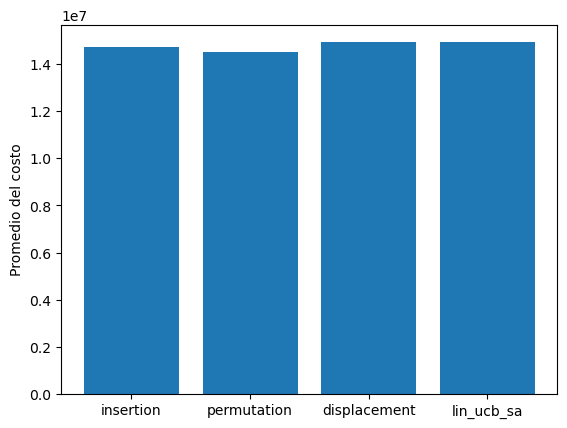

In [54]:
# Se grafica el costo promedio de cada operador

averages = {method: np.mean(costs) for method, costs in results.items()}

plt.bar(averages.keys(), averages.values())
plt.ylabel('Promedio del costo')
plt.show()

In [55]:
np.mean(results['lin_ucb_sa'])

14915385.454545455

In [56]:
np.mean(results['permutation'])

14513088.181818182

In [94]:
np.mean(results['swap'])

14045574.909090908

In [76]:
results["lin_ucb_sa"]

[14154272,
 14097472,
 14096812,
 14031876,
 14066992,
 14060420,
 14080526,
 14054642,
 14076438,
 13964076,
 14160708]

In [80]:
# Diferencia entre resultados de swap e lin_ucb_sa
(np.mean(results['swap']) - np.mean(results['lin_ucb_sa']))/np.mean(results['lin_ucb_sa']) * 100

-0.1855787539366723